In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec

In [2]:
TITLE_FONTSIZE = 18

In [3]:
df = pd.read_csv("./tools_list.tsv", sep="\t")


# Rename columns to one word
df.rename(
    columns={
        "Name of Tools/ Software/DB/Algorithm": "tool_name",
        "Category": "category",
        "Subcategory": "subcategory",
        "Abstract": "abstract",
        "Paper Title": "title",
        "Link to paper": "link",
        "Country of Affiliation of the Corresponding Author of the manuscript": "country",
        "Journal Name": "journal",
        "Year of publication from the link": "year",
        "Programming Language used to prepare the tool, primary software tool": "programming_language",
        "PI Name": "last_author",
    },
    inplace=True,
)

df = df[
    [
        "tool_name",
        "category",
        "subcategory",
        "title",
        "link",
        "journal",
        "country",
        "year",
        "programming_language",
        "last_author",
    ]
]


# Make 'year' column an integer for rows that are not NaN
df["year"] = pd.to_numeric(df["year"], errors="coerce").dropna().astype(int)
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")


df.head(1)

,tool_name,category,subcategory,title,link,journal,country,year,programming_language,last_author
0,CIDMD,Annotation,Spectrum prediction,Predicting Collision-Induced-Dissociation Tand...,https://pubs.acs.org/doi/10.1021/acs.jcim.4c00760,Journal of Chemical Information and Modeling,USA,2024,"Python, Shell",O Fiehn


Count programming languages

In [4]:
# Ensure NaNs are treated as empty strings, then split by ',' and strip whitespace
languages = (
    df["programming_language"]
    .fillna("")
    .apply(lambda x: [lang.strip() for lang in x.split(",") if lang.strip()])
)

# Flatten the list of lists into a single list, skip 'jupyter notebook' entries (case-insensitive)
all_languages = [
    lang
    for sublist in languages
    for lang in sublist
    if "notebook" not in lang.strip().lower()
]

# Remove "Webserver" from all_languages
all_languages = [
    lang for lang in all_languages if "webserver" not in lang.strip().lower()
]

# Remove "Not specified" and "NA" (case-insensitive) from list before counting
filtered_languages = [
    lang
    for lang in all_languages
    if lang.strip().lower()
    not in {
        "not specified",
        "na",
        "shell",
        "sccs",
        "database",
        "tex",
        "cmake",
        "gui",
        "scss",
        "fortran",
        "rez",
        "makefile",
        "ejs",
        "less",
        "css",
        "standalone",
        "html",
    }
]
# Count occurrences of each programming language
language_counter = Counter(filtered_languages)

Count Journals

In [5]:
# Count journals, ignore NaNs and harmonize the journal name by lower-casing, then capitalize
journals = df["journal"].dropna().apply(lambda x: x.strip().lower().capitalize())


# Capitalize all single-word journal names, otherwise capitalize only the first word
def smart_capitalize(journal):
    journal = journal.strip()
    if " " not in journal:
        return journal.capitalize()
    return " ".join([word.capitalize() for word in journal.split()])


journals = df["journal"].dropna().apply(lambda x: smart_capitalize(x.lower()))

journal_counter = Counter(journals)

Count categories

In [6]:
# Count occurrences of each category, clean up NaNs and whitespace, print top 10
category_counter = Counter(
    df["category"]
    .dropna()
    .apply(lambda x: [cat.strip() for cat in str(x).split("/")])
    .explode()
)

# Remove "DL" from category_counter since it's a category that can be duplicated
category_counter = Counter({k: v for k, v in category_counter.items() if k != "DL"})
# Rename "Quality Control" to "QC"
category_counter["QC"] = category_counter.pop("Quality Control")


def merge_others_and_split(subcat):
    # Split by "/", strip whitespace for each part
    subcats = [s.strip() for s in subcat.split("/")]
    # Apply "Others" merging logic to each part
    res = []
    for s in subcats:
        if s.lower().startswith("others"):
            res.append("Others")
        else:
            res.append(s)
    return res


subcategory_counter = Counter(
    df["subcategory"].dropna().apply(merge_others_and_split).explode()
)

subcategory_counter = Counter(
    {k.replace("|", "/"): v for k, v in subcategory_counter.items()}
)

Count countries

In [7]:
country_counter = Counter(
    df["country"].dropna().apply(lambda x: x.strip())  # ignore NaNs
)

Get last author name

In [8]:
last_author_counter = Counter(df["last_author"])

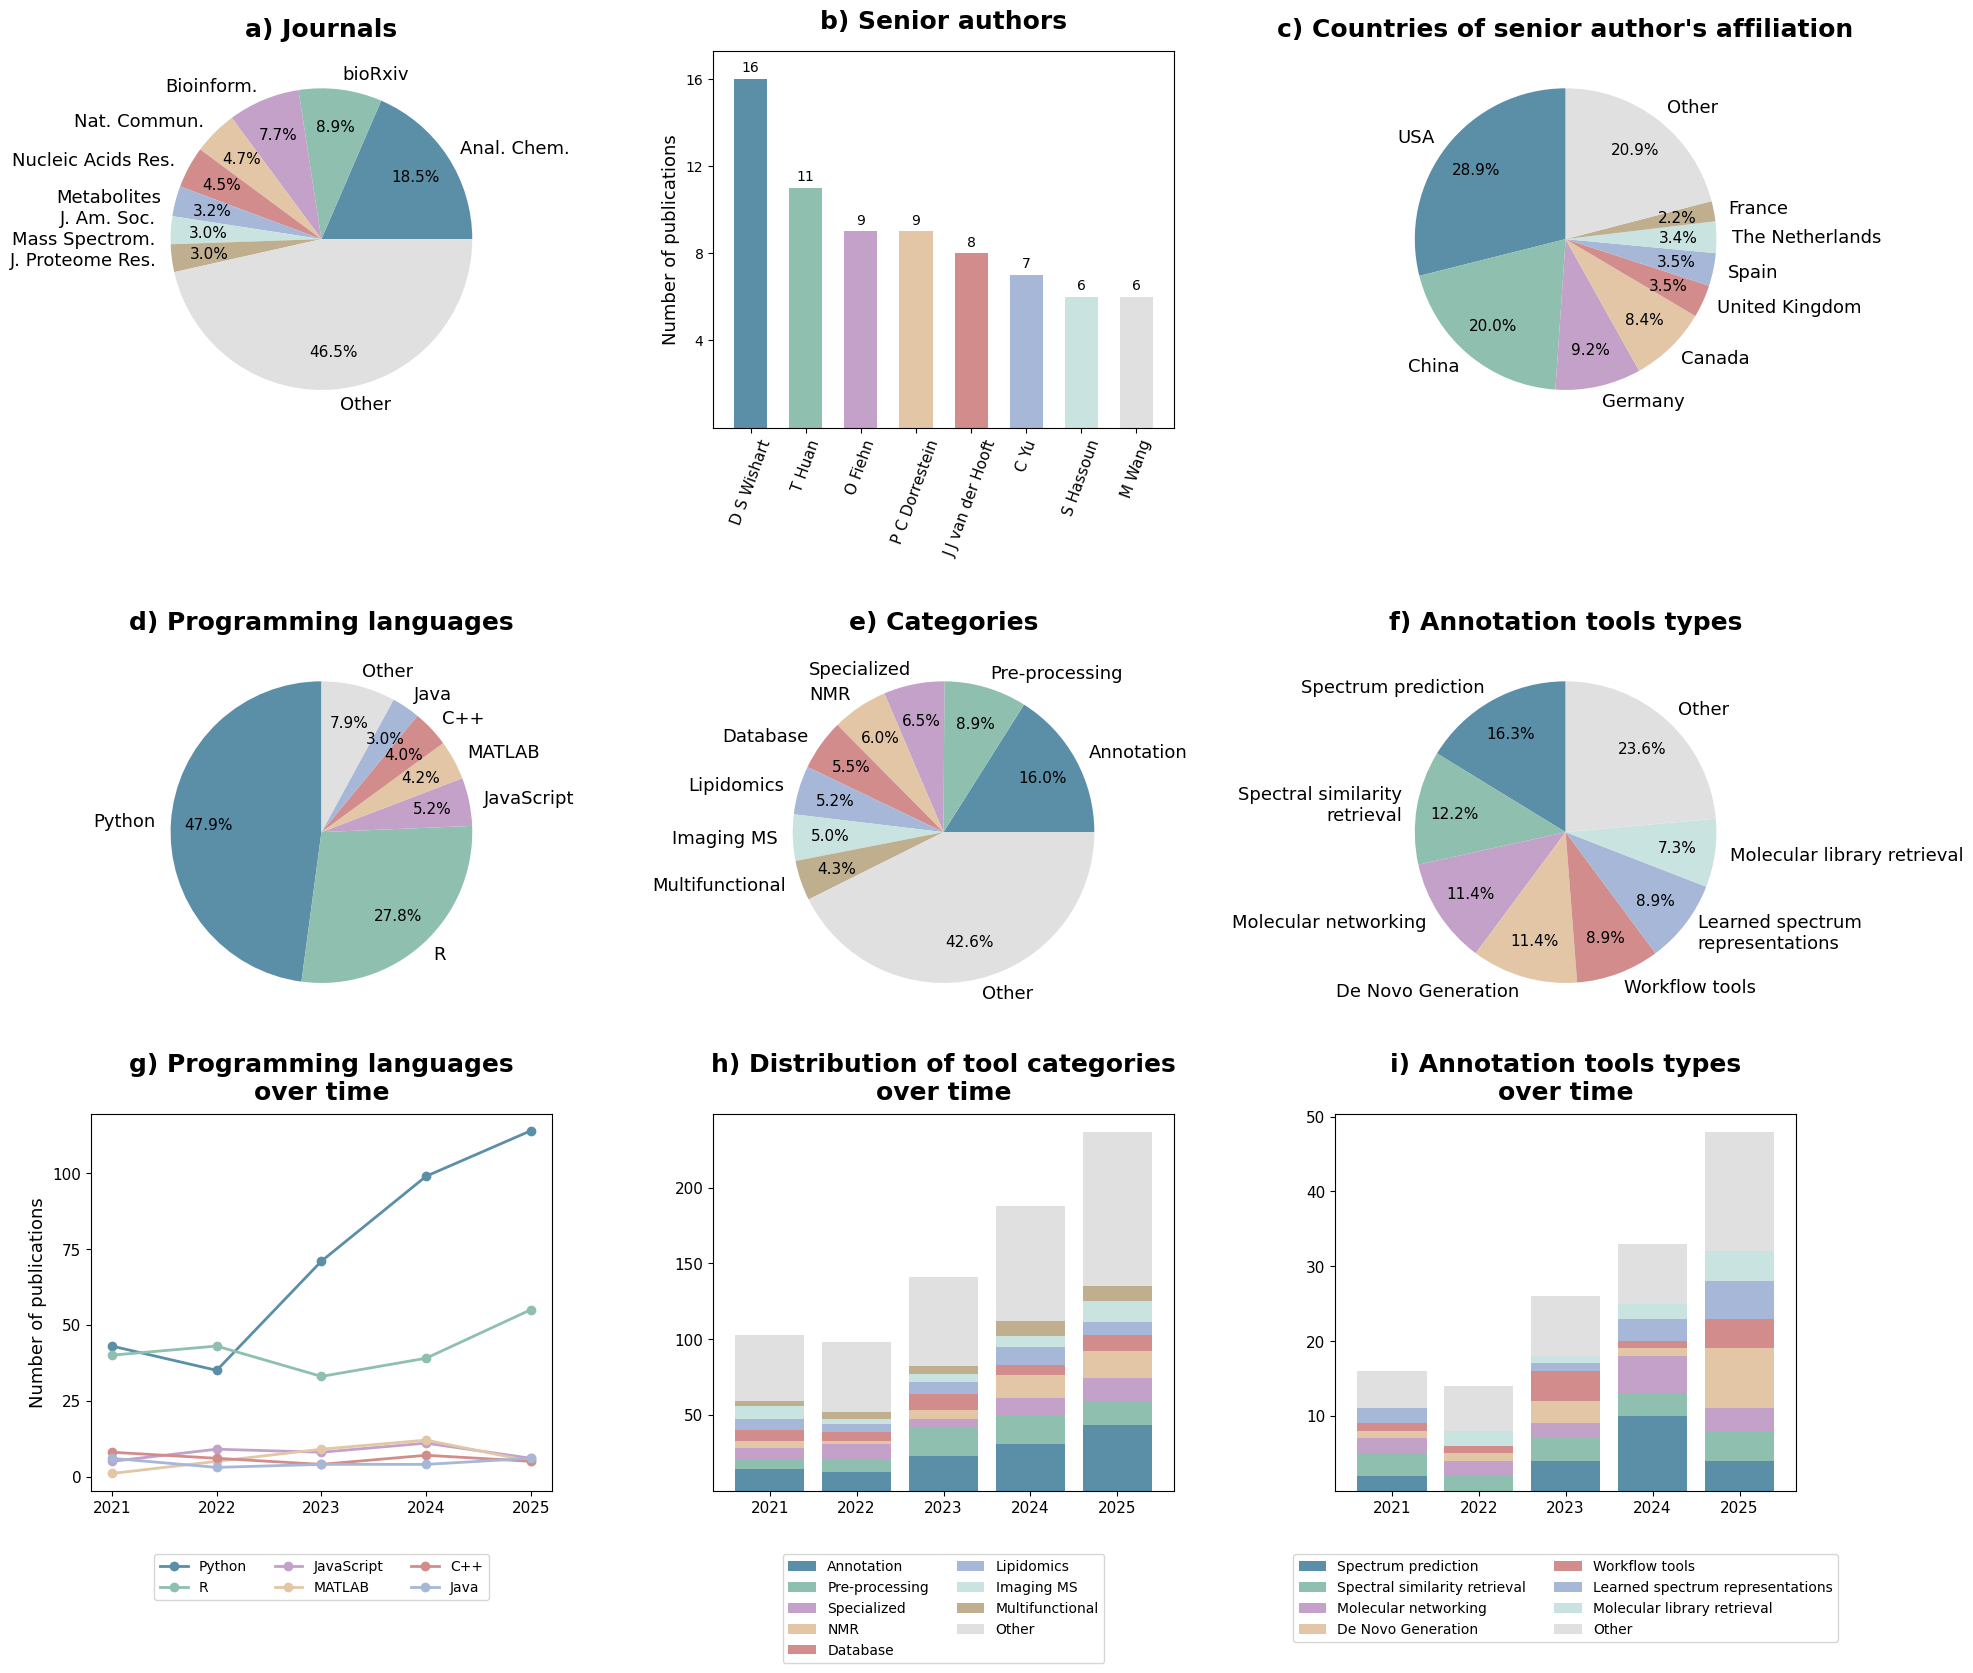

In [9]:
# custom_palette = [
#     "#CC9648",  # muted warm orange
#     "#65A7CC",  # soft sky blue
#     "#218469",  # matte teal
#     "#B36A9B",  # subdued magenta
#     "#D5CB67",  # dusty yellow
#     "#BC673B",  # earthy orange-red
#     "#8775D8",  # gentle violet
#     "#C64B87",  # matte pink
#     "#7B8C8E",  # elegant muted teal-gray
# ]

# Pastel
custom_palette = [
    "#5B8FA8",  # soft blue
    "#8EBFAF",  # pastel green
    "#C4A1C9",  # muted lilac
    "#E3C6A6",  # warm beige
    "#D28C8C",  # gentle rose
    "#A6B7D8",  # powder blue
    "#C9E3E0",  # pale aqua
    "#BFAF8F",  # taupe
]


# Define a dictionary to map long journal names to their acronyms
journal_acronyms = {
    "Journal Of The American Society For Mass Spectrometry": "J. Am. Soc.\nMass Spectrom.",
    # Add more as needed:
    "Analytical Chemistry": "Anal. Chem.",
    "Bioinformatics": "Bioinform.",
    "Journal Of Cheminformatics": "J. Chem. Inf. Model.",
    "Journal Of Proteome Research": "J. Proteome Res.",
    "Nature Communications": "Nat. Commun.",
    "Nucleic Acids Research": "Nucleic Acids Res.",
    "Bmc Bioinformatics": "BMC Bioin.",
    "Biorxiv": "bioRxiv",
    # Add more mappings as required
}


def map_journal_to_acronym(journal):
    return journal_acronyms.get(journal, journal)


# Make an acronym-mapped journal_counter for the plots
journal_counter_acronym = Counter()
for name, count in journal_counter.items():
    short = map_journal_to_acronym(name)
    journal_counter_acronym[short] += count


# Use first 5 for top items in pie, keeping a slot for "Other"
color_palette = custom_palette[:7] + [custom_palette[7]]
other_color = "#E0E0E0"  # Color for "Other"


def prepare_pie_data(counter, top_n=5):
    """
    Prepare data for pie chart: top N items + "Other" category
    Merges "Other" and "Others" into a single "Other" category
    """
    # Handle if counter is a list of tuples (from most_common)
    if isinstance(counter, list):
        counter_dict = dict(counter)
    else:
        # It's a Counter object
        counter_dict = dict(counter)

    # Merge "Other" and "Others" if they exist
    merged_dict = {}
    other_count_merged = 0
    for key, value in counter_dict.items():
        # Handle non-string keys (e.g., NaN floats)
        if isinstance(key, str):
            key_clean = key.lower()
        else:
            key_clean = str(key).lower() if pd.notna(key) else ""
        if key_clean in ["other", "others"]:
            other_count_merged += value
        else:
            merged_dict[key] = value

    # If we found "Other" or "Others", add them as a single "Other" entry
    if other_count_merged > 0:
        merged_dict["Other"] = other_count_merged

    # Helper function to safely get cleaned key
    def get_key_clean(key):
        if isinstance(key, str):
            return key.lower()
        else:
            return str(key).lower() if pd.notna(key) else ""

    # Get top N, excluding "Other" from the top list
    sorted_items = sorted(merged_dict.items(), key=lambda x: x[1], reverse=True)
    # Filter out "Other" from top items
    top_items = [(k, v) for k, v in sorted_items[:top_n] if get_key_clean(k) != "other"]
    # Get "Other" if it exists and wasn't in top N
    other_item = [(k, v) for k, v in sorted_items if get_key_clean(k) == "other"]
    # Get remaining items (not in top and not "Other")
    remaining_items = [
        (k, v) for k, v in sorted_items[top_n:] if get_key_clean(k) != "other"
    ]

    # Calculate total "Other" count
    other_count = sum(v for _, v in other_item) + sum(v for _, v in remaining_items)

    # Prepare labels and sizes
    labels = [item[0] for item in top_items]
    sizes = [item[1] for item in top_items]

    if other_count > 0:
        labels.append("Other")
        sizes.append(other_count)

    return labels, sizes


# Prepare data for time-series visualizations
# Filter out rows with missing years
df_with_year = df[df["year"].notna()].copy()

# 1. Distribution of tool categories across years (stacked bar chart)
category_year_data = []
for _, row in df_with_year.iterrows():
    year = row["year"]
    if pd.notna(row["category"]):
        categories = [cat.strip() for cat in str(row["category"]).split("/")]
        for cat in categories:
            if cat:  # Skip empty strings
                category_year_data.append({"year": year, "category": cat})

category_year_df = pd.DataFrame(category_year_data)
if len(category_year_df) > 0:
    category_year_counts = (
        category_year_df.groupby(["year", "category"]).size().unstack(fill_value=0)
    )
    # Get top categories
    top_categories = category_counter.most_common(8)
    top_category_names = [cat for cat, _ in top_categories]
    # Reindex to include all years and fill missing with 0
    all_years = sorted([int(y) for y in df_with_year["year"].dropna().unique()])
    category_year_counts = category_year_counts.reindex(all_years, fill_value=0)
    category_year_counts.index = category_year_counts.index.astype(int)
else:
    category_year_counts = pd.DataFrame()
    top_category_names = []

# 2. Programming languages used over time (line chart)
language_year_data = []
for _, row in df_with_year.iterrows():
    year = row["year"]
    if pd.notna(row["programming_language"]):
        languages = [
            lang.strip()
            for lang in str(row["programming_language"]).split(",")
            if lang.strip()
        ]
        for lang in languages:
            if "notebook" not in lang.lower():
                language_year_data.append({"year": year, "language": lang})

language_year_df = pd.DataFrame(language_year_data)
if len(language_year_df) > 0:
    language_year_counts = (
        language_year_df.groupby(["year", "language"]).size().unstack(fill_value=0)
    )
    # Get top languages
    top_languages = language_counter.most_common(6)
    top_language_names = [lang for lang, _ in top_languages]
    # Reindex to include all years
    all_years = sorted([int(y) for y in df_with_year["year"].dropna().unique()])
    language_year_counts = language_year_counts.reindex(all_years, fill_value=0)
    language_year_counts.index = language_year_counts.index.astype(int)
else:
    language_year_counts = pd.DataFrame()
    top_language_names = []

# 3. Growth of subcategories over time (stacked bar chart)
subcategory_year_data = []
for _, row in df_with_year.iterrows():
    year = row["year"]
    if pd.notna(row["subcategory"]):
        subcategory_year_data.append(
            {"year": year, "subcategory": str(row["subcategory"]).strip()}
        )

subcategory_year_df = pd.DataFrame(subcategory_year_data)
if len(subcategory_year_df) > 0:
    subcategory_year_counts = (
        subcategory_year_df.groupby(["year", "subcategory"])
        .size()
        .unstack(fill_value=0)
    )
    # Get top subcategories
    top_subcategories = subcategory_counter.most_common(8)
    top_subcategory_names = [subcat for subcat, _ in top_subcategories]
    # Reindex to include all years
    all_years = sorted([int(y) for y in df_with_year["year"].dropna().unique()])
    subcategory_year_counts = subcategory_year_counts.reindex(all_years, fill_value=0)
    subcategory_year_counts.index = subcategory_year_counts.index.astype(int)
else:
    subcategory_year_counts = pd.DataFrame()
    top_subcategory_names = []

fig = plt.figure(figsize=(22, 18))
# Create GridSpec with custom height ratios to control spacing
# Using 4 rows: row0=plots, row1=spacer, row2=plots, row3=plots
gs = GridSpec(4, 3, figure=fig, height_ratios=[1, 0.08, 1, 1], hspace=0.32, wspace=0.35)

# Create axes: first row uses gs[0,:], second row uses gs[2,:], third row uses gs[3,:]
axes = []
for col in range(3):
    axes.append(fig.add_subplot(gs[0, col]))  # First row
for col in range(3):
    axes.append(fig.add_subplot(gs[2, col]))  # Second row
for col in range(3):
    axes.append(fig.add_subplot(gs[3, col]))  # Third row

# List of counters and their titles for first 6 plots
# First row: Journals (left), Last Authors (mid), Countries (right)
# Second row: Programming Languages (left), Categories (mid), Annotation subtypes (right)
counters = [
    (journal_counter_acronym, "a) Journals", 8),  # axes[0] - First row, left
    (last_author_counter, "b) Senior authors", 8),  # axes[1] - First row, mid
    (
        country_counter,
        "c) Countries of senior author's affiliation",
        8,
    ),  # axes[2] - First row, right
    (language_counter, "d) Programming languages", 6),  # axes[3] - Second row, left
    (category_counter, "e) Categories", 8),  # axes[4] - Second row, mid
    (
        subcategory_counter,
        "f) Annotation tools types",
        8,
    ),  # axes[5] - Second row, right
]

for idx, (counter, title, top_n) in enumerate(counters):
    ax = axes[idx]  # alias for readability

    if title == "b) Senior authors":
        if isinstance(counter, list):
            counter_dict = dict(counter)
        else:
            counter_dict = dict(counter)

        # First, merge "Other" and "Others" into a single "Other" entry
        merged_dict = {}
        other_count_merged = 0
        for key, value in counter_dict.items():
            # Handle non-string keys (e.g., NaN floats)
            if not isinstance(key, str):
                key_str = str(key) if pd.notna(key) else "(blank)"
            else:
                key_str = key
            key_clean = key_str.strip().lower()
            if key_clean in ["other", "others"]:
                other_count_merged += value
            else:
                merged_dict[key] = value

        # Add merged "Other" if it exists
        if other_count_merged > 0:
            merged_dict["Other"] = other_count_merged

        sorted_items = sorted(merged_dict.items(), key=lambda x: x[1], reverse=True)

        # Helper function to safely get cleaned key
        def get_key_clean(key):
            if not isinstance(key, str):
                key_str = str(key) if pd.notna(key) else "(blank)"
            else:
                key_str = key
            return key_str.strip().lower()

        # Exclude "Other" from top items
        top_items = [
            item for item in sorted_items[:top_n] if get_key_clean(item[0]) != "other"
        ]
        # Get remaining items (those not in top N, excluding "Other")
        remaining_items = [
            item for item in sorted_items[top_n:] if get_key_clean(item[0]) != "other"
        ]
        # Get "Other" if it exists (could be in top N or after)
        other_item = [
            item for item in sorted_items if get_key_clean(item[0]) == "other"
        ]

        authors = []
        for item in top_items:
            key = item[0]
            if isinstance(key, str):
                author_name = key if key.strip() != "" else "(blank)"
            elif pd.notna(key):
                author_name = str(key)
            else:
                author_name = "(blank)"
            authors.append(author_name)
        counts = [item[1] for item in top_items]

        bars = ax.bar(
            authors,
            counts,
            color=color_palette[: len(authors) - 1] + [other_color],
            width=0.6,
        )

        ax.set_xlabel("")
        ax.set_ylabel("Number of publications", fontsize=13)
        ax.tick_params(axis="x", labelrotation=70, labelsize=11)

        # Set the max number of y ticks to 5
        ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=5, prune="lower"))

        # Reduce title font size for less crowding, and add a bit more padding
        ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight="bold", pad=16)

        for bar in bars:

            height = bar.get_height()

            if height > 50:
                continue

            ax.annotate(
                f"{int(height)}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=10,
            )
        ax.margins(y=0.08)  # slightly more margin for log bars

    else:
        labels, sizes = prepare_pie_data(counter, top_n=top_n)

        # Split "Formula/class/property prediction" into two lines for Annotation subtypes
        if title == "f) Annotation tools types":
            labels = [
                label.replace(
                    "Formula/class/property prediction",
                    "Formula/class/property\nprediction",
                )
                for label in labels
            ]
            labels = [
                label.replace(
                    "Learned spectrum representations",
                    "Learned spectrum\nrepresentations",
                )
                for label in labels
            ]
            labels = [
                label.replace(
                    "Spectral similarity retrieval",
                    "Spectral similarity\nretrieval",
                )
                for label in labels
            ]

        n_top = len(labels) - (1 if "Other" in labels else 0)
        colors = list(color_palette[:n_top])
        if "Other" in labels:
            colors.append(other_color)

        ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight="bold", pad=10)
        ax.axis("equal")

        wedges, texts, autotexts = ax.pie(
            sizes,
            labels=labels,
            autopct="%1.1f%%",
            startangle=0 if title in ["e) Categories", "a) Journals"] else 90,
            colors=colors,
            textprops={"fontsize": 13},
            pctdistance=0.75,
        )
        for text in texts:
            text.set_fontsize(13)
        for autotext in autotexts:
            autotext.set_fontsize(11)

# Add three new time-series visualizations in the bottom row (axes 6, 7, 8)
# Third row: Programming languages used over time (left), Distribution of tool categories across years (mid), Annotation tools subtypes over time (right)

# 1. Programming languages used over time (line chart) - axes[6]
ax = axes[6]
if len(language_year_counts) > 0 and len(top_language_names) > 0:
    # Select top languages
    plot_languages = [
        lang for lang in top_language_names if lang in language_year_counts.columns
    ]

    # Create line chart
    for i, lang in enumerate(plot_languages):
        if lang in language_year_counts.columns:
            ax.plot(
                language_year_counts.index,
                language_year_counts[lang],
                marker="o",
                label=lang,
                linewidth=2,
                markersize=6,
                color=color_palette[i % len(color_palette)],
            )

    ax.set_title(
        "g) Programming languages\nover time",
        fontsize=TITLE_FONTSIZE,
        fontweight="bold",
        pad=10,
    )
    ax.set_xlabel("", fontsize=13)
    ax.set_ylabel("Number of publications", fontsize=13)
    ax.legend(
        title="",
        fontsize=10,
        title_fontsize=11,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=3,
        frameon=True,
    )
    ax.tick_params(axis="x", labelsize=11)
    ax.tick_params(axis="y", labelsize=11)
    # Format x-axis years as integers
    ax.set_xticks(language_year_counts.index)
    ax.set_xticklabels([int(x) for x in language_year_counts.index], rotation=0)
    # Remove 0 from y-axis ticks and set 5 ticks
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=5, prune="lower"))

# 2. Distribution of tool categories across years (stacked bar chart) - axes[7]
ax = axes[7]
if len(category_year_counts) > 0 and len(top_category_names) > 0:
    # Select top categories, but exclude "Other"/"Others" from the top list
    plot_categories = [
        cat
        for cat in top_category_names
        if cat in category_year_counts.columns
        and cat.lower() not in ["other", "others"]
    ]
    other_cats = [
        cat for cat in category_year_counts.columns if cat not in plot_categories
    ]

    # Check if "Other" or "Others" already exists (either in other_cats or was in top list)
    existing_other = [cat for cat in other_cats if cat.lower() in ["other", "others"]]
    # Also check if "Other"/"Others" was in the top list but we excluded it
    excluded_from_top = [
        cat
        for cat in top_category_names
        if cat in category_year_counts.columns and cat.lower() in ["other", "others"]
    ]
    existing_other.extend(excluded_from_top)

    remaining_cats = [
        cat for cat in other_cats if cat.lower() not in ["other", "others"]
    ]

    # Combine existing "Other"/"Others" with remaining categories
    all_other_cats = existing_other + remaining_cats

    plot_data = category_year_counts[plot_categories].copy()
    if len(all_other_cats) > 0:
        plot_data["Other"] = category_year_counts[all_other_cats].sum(axis=1)

    # Assign colors explicitly: use palette for categories, other_color for "Other"
    plot_colors = []
    color_idx = 0
    for col in plot_data.columns:
        if col == "Other":
            plot_colors.append(other_color)
        else:
            # Use colors from palette, cycling if needed
            plot_colors.append(color_palette[color_idx % len(color_palette)])
            color_idx += 1

    # Create stacked bar chart
    plot_data.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=plot_colors,
        width=0.8,
    )
    ax.set_title(
        "h) Distribution of tool categories\nover time",
        fontsize=TITLE_FONTSIZE,
        fontweight="bold",
        pad=10,
    )
    ax.set_xlabel("", fontsize=13)
    ax.set_ylabel("", fontsize=13)
    ax.legend(
        title="",
        fontsize=10,
        title_fontsize=11,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
    )
    ax.tick_params(axis="x", labelrotation=0, labelsize=11)
    ax.tick_params(axis="y", labelsize=11)
    ax.set_xticklabels([int(x) for x in plot_data.index], rotation=0)
    # Remove 0 from y-axis ticks and set 5 ticks
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=6, prune="lower"))

# 3. Annotation tools subtypes over time (stacked bar chart) - axes[8]
ax = axes[8]
if len(subcategory_year_counts) > 0 and len(top_subcategory_names) > 0:
    # Select top subcategories, but exclude "Other"/"Others" from the top list
    plot_subcategories = [
        subcat
        for subcat in top_subcategory_names
        if subcat in subcategory_year_counts.columns
        and subcat.lower() not in ["other", "others"]
    ]
    other_subcats = [
        subcat
        for subcat in subcategory_year_counts.columns
        if subcat not in plot_subcategories
    ]

    # Check if "Other" or "Others" already exists (either in other_subcats or was in top list)
    existing_other = [
        subcat for subcat in other_subcats if subcat.lower() in ["other", "others"]
    ]
    # Also check if "Other"/"Others" was in the top list but we excluded it
    excluded_from_top = [
        subcat
        for subcat in top_subcategory_names
        if subcat in subcategory_year_counts.columns
        and subcat.lower() in ["other", "others"]
    ]
    existing_other.extend(excluded_from_top)

    remaining_subcats = [
        subcat for subcat in other_subcats if subcat.lower() not in ["other", "others"]
    ]

    # Combine existing "Other"/"Others" with remaining subcategories
    all_other_subcats = existing_other + remaining_subcats

    plot_data = subcategory_year_counts[plot_subcategories].copy()
    if len(all_other_subcats) > 0:
        plot_data["Other"] = subcategory_year_counts[all_other_subcats].sum(axis=1)

    # Assign colors explicitly: use palette for subcategories, other_color for "Other"
    plot_colors = []
    color_idx = 0
    for col in plot_data.columns:
        if col == "Other":
            plot_colors.append(other_color)
        else:
            # Use colors from palette, cycling if needed
            plot_colors.append(color_palette[color_idx % len(color_palette)])
            color_idx += 1

    # Create stacked bar chart
    plot_data.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=plot_colors,
        width=0.8,
    )
    ax.set_title(
        "i) Annotation tools types\nover time",
        fontsize=TITLE_FONTSIZE,
        fontweight="bold",
        pad=10,
    )
    ax.set_xlabel("", fontsize=13)
    ax.set_ylabel("", fontsize=13)
    ax.legend(
        title="",
        fontsize=10,
        title_fontsize=11,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
    )
    ax.tick_params(axis="x", labelrotation=0, labelsize=11)
    ax.tick_params(axis="y", labelsize=11)
    ax.set_xticklabels([int(x) for x in plot_data.index], rotation=0)
    # Remove 0 from y-axis ticks and set 5 ticks
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=6, prune="lower"))

# Adjust bottom margin for legends
plt.subplots_adjust(bottom=0.08)

plt.show()